In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, SMAIndicator
from ta.volatility import BollingerBands
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [80]:
#삼성전자 데이터 다운로드
ticker = '005930.KS'
data = yf.download(ticker, start="2015-01-01", end="2024-01-01")
data = data[['Close', 'Volume']]
data = data.dropna()
print(data)
print(data.isna().sum())

[*********************100%%**********************]  1 of 1 completed

              Close    Volume
Date                         
2015-01-02  26600.0   8774950
2015-01-05  26660.0  10139500
2015-01-06  25900.0  15235500
2015-01-07  26140.0  14322750
2015-01-08  26280.0  14477600
...             ...       ...
2023-12-21  75000.0  13478766
2023-12-22  75900.0  14515608
2023-12-26  76600.0  13164909
2023-12-27  78000.0  20651042
2023-12-28  78500.0  17797536

[2211 rows x 2 columns]
Close     0
Volume    0
dtype: int64


In [81]:
#지표 계산
rsi_period = 14
rsi = RSIIndicator(close=data['Close'], window=rsi_period)
data['RSI'] = rsi.rsi()

macd = MACD(data['Close'], window_slow=26, window_fast=12, window_sign=9)
data['MACD Line'] = macd.macd()
data['Signal Line'] = macd.macd_signal()
data['MACD Histogram'] = macd.macd_diff()

#결측값제거
data = data.dropna()
print(data)
print(data.isna().sum())

              Close    Volume        RSI    MACD Line  Signal Line  \
Date                                                                 
2015-02-23  27340.0  15301800  51.787193   105.703465   131.066712   
2015-02-24  27340.0  10863250  51.787193    97.125612   124.278492   
2015-02-25  27580.0   8374250  55.678931   108.443527   121.111499   
2015-02-26  27500.0   8179150  54.110989   109.693248   118.827849   
2015-02-27  27140.0  13009400  47.613223    80.704361   111.203151   
...             ...       ...        ...          ...          ...   
2023-12-21  75000.0  13478766  66.926481   835.827173   692.354434   
2023-12-22  75900.0  14515608  70.533443   973.496903   748.582928   
2023-12-26  76600.0  13164909  72.999865  1126.104276   824.087197   
2023-12-27  78000.0  20651042  77.123999  1344.516272   928.173012   
2023-12-28  78500.0  17797536  78.393348  1540.200698  1050.578549   

            MACD Histogram  
Date                        
2015-02-23      -25.363246  
20

In [82]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close', 'RSI', 'MACD Histogram']])

def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, :])
        y.append(dataset[i, 0])  # 다음날 종가 예측
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

In [83]:
# LSTM 모델 생성
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=10, batch_size=32)

predictions = model.predict(X)
predictions_close = predictions[:, 0].reshape(-1, 1)
scaler_close = MinMaxScaler()
scaler_close.min_, scaler_close.scale_ = scaler.min_[0], scaler.scale_[0]
predictions_close = scaler_close.inverse_transform(predictions_close)
data['Predictions'] = np.nan
data.iloc[time_step:len(data), -1] = predictions_close.flatten()

Epoch 1/10
67/67 [==============================] - 8s 48ms/step - loss: 0.0234
Epoch 2/10
67/67 [==============================] - 3s 48ms/step - loss: 0.0033
Epoch 3/10
67/67 [==============================] - 3s 52ms/step - loss: 0.0027
Epoch 4/10
67/67 [==============================] - 3s 50ms/step - loss: 0.0026
Epoch 5/10
67/67 [==============================] - 4s 55ms/step - loss: 0.0022
Epoch 6/10
67/67 [==============================] - 4s 52ms/step - loss: 0.0026
Epoch 7/10
67/67 [==============================] - 3s 51ms/step - loss: 0.0023
Epoch 8/10
67/67 [==============================] - 3s 50ms/step - loss: 0.0023
Epoch 9/10
67/67 [==============================] - 3s 46ms/step - loss: 0.0023
Epoch 10/10
67/67 [==============================] - 2s 18ms/step


In [84]:
# 매매 신호
data['Signal'] = 0
profit_threshold = 0.03  # 이익 목표: 3%
stop_loss_threshold = 0.005  # 손실 제한: 0.5%

predictions_trimmed = predictions_close[-len(data)+time_step-1:-1]
holding = False

for i in range(time_step-1, len(data)-2):
    if not holding:
        if predictions_trimmed[i-(time_step-1)] > data['Close'].shift(1).iloc[i]:
            data.loc[data.index[i], 'Signal'] = 1 
            holding = True
            buy_price = data['Close'].iloc[i+1]
    else:
        current_price = data['Close'].iloc[i+1]
        if current_price >= buy_price * (1 + profit_threshold):
            data.loc[data.index[i], 'Signal'] = -1
            holding = False
        elif current_price <= buy_price * (1 - stop_loss_threshold):
            data.loc[data.index[i], 'Signal'] = -1
            holding = False

# 포지션 생성
data['Position'] = data['Signal'].shift()

# 수익률 계산 (초기 자본 = 100만원)
initial_capital = 1000000
data['Daily Return'] = data['Close'].pct_change()
data['Strategy Return'] = data['Daily Return'] * data['Position']
data['Cumulative Market Return'] = (1 + data['Daily Return']).cumprod() * initial_capital
data['Cumulative Strategy Return'] = (1 + data['Strategy Return']).cumprod() * initial_capital

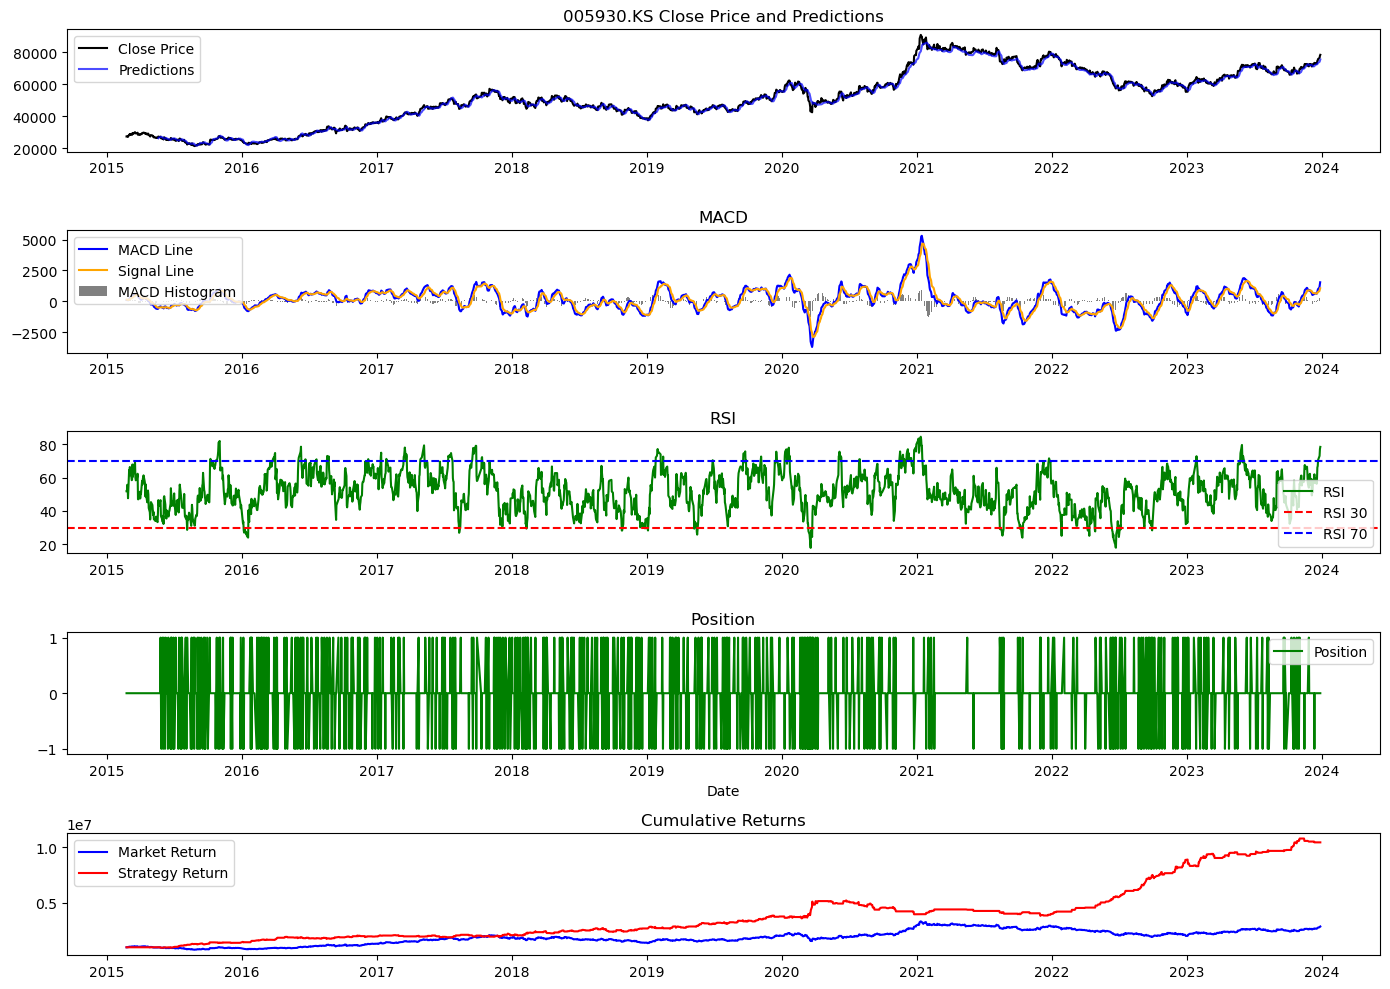

In [85]:
#그래프
plt.figure(figsize=(14, 10))

plt.subplot(5, 1, 1)
plt.plot(data.index, data['Close'], label='Close Price', color='black')
plt.plot(data.index, data['Predictions'], label='Predictions', color='blue', alpha=0.7)
plt.title(f'{ticker} Close Price and Predictions')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(data.index, data['MACD Line'], label='MACD Line', color='blue')
plt.plot(data.index, data['Signal Line'], label='Signal Line', color='orange')
plt.bar(data.index, data['MACD Histogram'], label='MACD Histogram', color='gray')
plt.title('MACD')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(data.index, data['RSI'], label='RSI', color='green')
plt.axhline(y=30, color='r', linestyle='--', label='RSI 30')
plt.axhline(y=70, color='b', linestyle='--', label='RSI 70')
plt.title('RSI')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(data.index, data['Position'], label='Position', color='green')
plt.title('Position')
plt.xlabel('Date')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(data.index, data['Cumulative Market Return'], label='Market Return', color='blue')
plt.plot(data.index, data['Cumulative Strategy Return'], label='Strategy Return', color='red')
plt.title('Cumulative Returns')
plt.legend()

plt.tight_layout()
plt.show()

In [86]:
final_capital = data['Cumulative Strategy Return'].iloc[-1]
multiple = final_capital / initial_capital
print(f"마지막 누적 전략 수익률: {multiple:.2f}")

마지막 누적 전략 수익률: 10.44
